In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../scripts/')
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.stats import pearsonr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from epsilon_tools import *
from tools import alphabet

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.2)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

warnings.simplefilter('ignore')

In [3]:
ds = xr.open_mfdataset('../data/niw2016/7786a/*.nc')

In [10]:
ds.eps1_kra.values.shape

(65548,)

In [14]:
ds.z.values.shape

(65548,)

In [73]:
(ds.z.diff('time')>10).compute()

<xarray.DataArray 'z' (time: 65547)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 2016-08-25T20:39:53 ... 2016-11-05T02:29:02
    z        (time) float64 -492.0 -490.6 -489.2 ... -2.294 -1.158 -0.02153

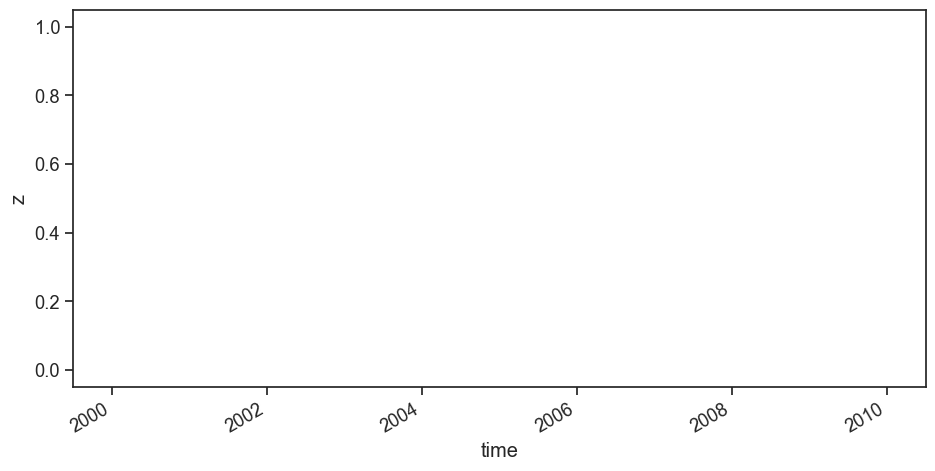

In [74]:
# ds.z.plot()
ds.z.where((ds.z.diff('time')>10).compute()).plot(marker='o',color='r')
# plt.ylim(-20,0)

In [59]:
ds['eps_log'] = np.log10( ds.eps1_kra ).compute()
ds['eps_rc_log'] = np.log10( ds.eps1_rc ).compute()

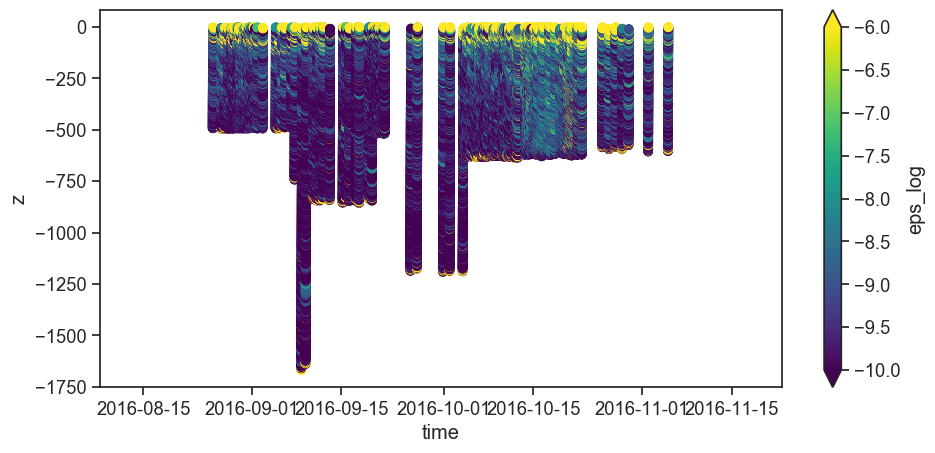

In [57]:
ds.plot.scatter(x='time',y='z',hue='eps_log',vmin=-10,vmax=-6)

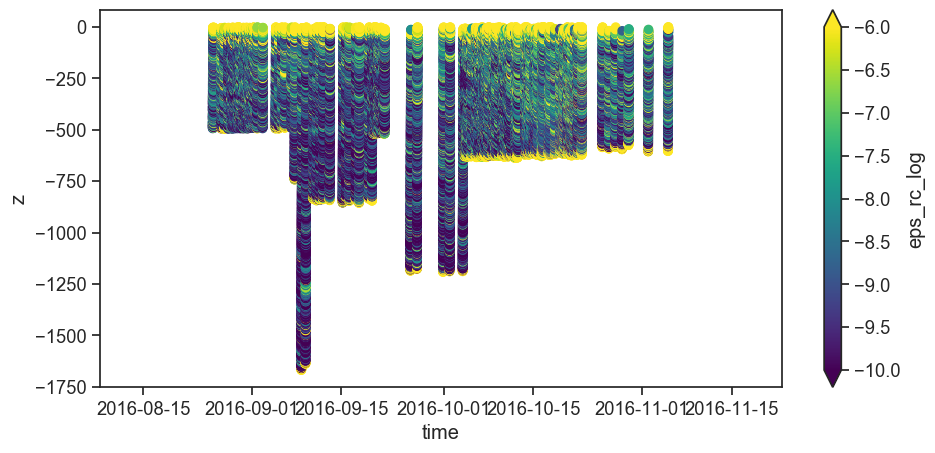

In [60]:
ds.plot.scatter(x='time',y='z',hue='eps_rc_log',vmin=-10,vmax=-6)

In [61]:
ds

<xarray.Dataset>
Dimensions:          (f_cps: 20, time: 65548)
Coordinates:
  * f_cps            (f_cps) float64 0.125 0.175 0.225 0.3 ... 28.33 39.08 53.9
  * time             (time) datetime64[ns] 2016-08-25T20:39:43 ... 2016-11-05T02:29:02
    z                (time) float64 dask.array<chunksize=(386,), meta=np.ndarray>
    k_rpm            (time, f_cps) float64 dask.array<chunksize=(386, 20), meta=np.ndarray>
Data variables:
    dof              (time, f_cps) float64 dask.array<chunksize=(386, 20), meta=np.ndarray>
    p                (time) float64 dask.array<chunksize=(386,), meta=np.ndarray>
    N2               (time) float64 dask.array<chunksize=(386,), meta=np.ndarray>
    N                (time) float64 dask.array<chunksize=(386,), meta=np.ndarray>
    T                (time) float64 dask.array<chunksize=(386,), meta=np.ndarray>
    dTdz             (time) float64 dask.array<chunksize=(386,), meta=np.ndarray>
    w                (time) float64 dask.array<chunksize=(386,), 